In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy.external as sce
import decoupler as dc
import numpy as np
import math
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [2]:
adata=ad.read_h5ad("./results_preneopl_acinar_harm.h5ad")

In [3]:
adata.obs["anno_TM"] = adata.obs["anno_TM"].astype('str')

In [4]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col='dataset',
    groups_col='anno_TM',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

AnnData object with n_obs × n_vars = 20 × 19384
    obs: 'dataset', 'anno_TM', 'in_tissue', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'psbulk_n_cells', 'psbulk_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    layers: 'psbulk_props'

In [5]:
pp_pdata = pdata.copy()
sc.pp.normalize_total(pp_pdata, target_sum=1e6)
sc.pp.log1p(pp_pdata)
sc.pp.scale(pp_pdata, max_value=10)
sc.tl.pca(pp_pdata, n_comps=10)

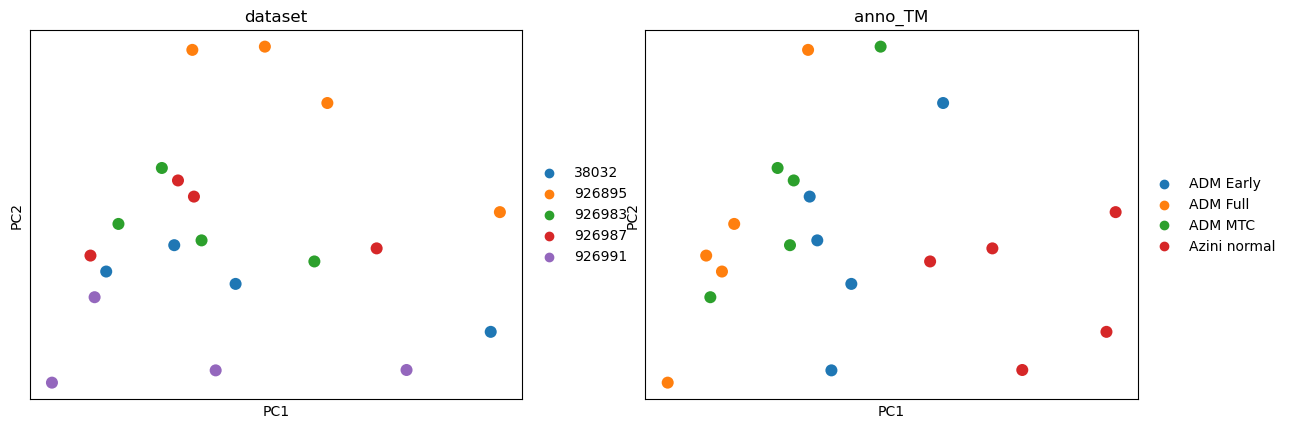

In [6]:
sc.pl.pca(pp_pdata, color=['dataset', 'anno_TM'], ncols=2, show=True, size=300)

In [7]:
dc.get_metadata_associations(
    pp_pdata,
    obs_keys = ['anno_TM', 'dataset', 'psbulk_n_cells', 'psbulk_counts'], #metadata columns to associate to PCs
    obsm_key='X_pca',
    uns_key='pca_anova',
    inplace=True
)

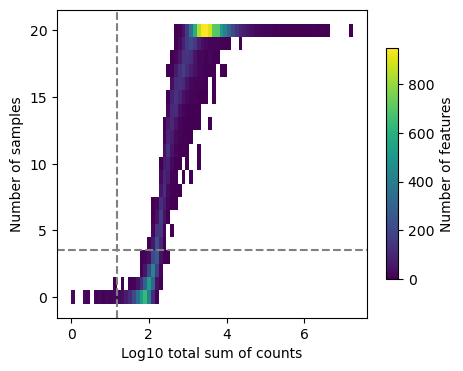

In [9]:
dc.plot_filter_by_expr(pdata, group='dataset', min_count=10, min_total_count=15)

In [10]:
genes = dc.filter_by_expr(pdata, group='dataset', min_count=10, min_total_count=15)

pdata_f = pdata[:, genes].copy()
pdata_f

AnnData object with n_obs × n_vars = 20 × 13949
    obs: 'dataset', 'anno_TM', 'in_tissue', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'psbulk_n_cells', 'psbulk_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    layers: 'psbulk_props'

In [11]:
#one vs one
pdata_f.obs["anno-TM"]=pdata_f.obs["anno_TM"]
b_list = ["Azini normal", "ADM Early", "ADM Full", "ADM MTC"]
a_list = ["Azini normal", "ADM Early", "ADM Full", "ADM MTC"]
results_df={}
coff={}

for b in b_list:
    for a in a_list:
        if a != b:
            dds = DeseqDataSet(
                adata=pdata_f,
                design_factors="anno-TM",
                ref_level = ["anno-TM", a],
                refit_cooks=True,
                #n_cpus=8,
                )
            dds.deseq2()
            stat_res = DeseqStats(dds, contrast=["anno-TM", b , a]) #n_cpus=8
            stat_res.summary()
            coff[a]=f"anno-TM_{b}_vs_{a}"
            stat_res.lfc_shrink(coeff=coff[a])
            results_df[a] = stat_res.results_df   
            results_df[a].to_csv(f"./diff_exp_genes/CSVs/preneopl_acinar_{b}_vs_{a}.csv")

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 24.93 seconds.

Fitting dispersion trend curve...
... done in 1.09 seconds.

Fitting MAP dispersions...
... done in 30.54 seconds.

Fitting LFCs...
... done in 3.31 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 2.07 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: anno-TM Azini normal vs ADM Early
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.728576  0.778493 -0.935880  0.349335   
0610010F05Rik   97.461525        0.565545  0.234585  2.410831  0.015916   
0610010K14Rik   78.045776        0.157520  0.165051  0.954376  0.339893   
0610012G03Rik  155.581757        0.415195  0.214981  1.931306  0.053445   
0610030E20Rik  111.129044        0.205154  0.178855  1.147038  0.251366   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.308665  0.259537  1.189289  0.234326   
Zyx            435.217102       -0.434135  0.121670 -3.568132  0.000360   
Zzef1           89.108749       -0.168346  0.217747 -0.773127  0.439447   
Zzz3            48.378254        0.258240  0.370293  0.697393  0.485557   
ccdc198         29.700750        0.108180  0.359144  0.301215  0.763250   

                   padj  
0

... done in 5.04 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM Azini normal vs ADM Early
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.061209  0.193295 -0.935880  0.349335   
0610010F05Rik   97.461525        0.406011  0.249227  2.410831  0.015916   
0610010K14Rik   78.045776        0.108346  0.130717  0.954376  0.339893   
0610012G03Rik  155.581757        0.275781  0.202151  1.931306  0.053445   
0610030E20Rik  111.129044        0.135246  0.142842  1.147038  0.251366   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.153577  0.181483  1.189289  0.234326   
Zyx            435.217102       -0.390410  0.123550 -3.568132  0.000360   
Zzef1           89.108749       -0.093278  0.151033 -0.773127  0.439447   
Zzz3            48.378254        0.076692  0.177009  0.697393  0.485557   
ccdc198         29.700750        0.032496  0.166021  0.301215  0.763250   

                   p

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 29.69 seconds.

Fitting dispersion trend curve...
... done in 1.05 seconds.

Fitting MAP dispersions...
... done in 30.61 seconds.

Fitting LFCs...
... done in 3.20 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 1.91 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: anno-TM Azini normal vs ADM Full
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.417980  0.730110 -0.572489  0.566991   
0610010F05Rik   97.461525        0.750351  0.228373  3.285640  0.001018   
0610010K14Rik   78.045776        0.308716  0.179109  1.723619  0.084777   
0610012G03Rik  155.581757        0.347021  0.205879  1.685556  0.091881   
0610030E20Rik  111.129044        0.080105  0.163816  0.488997  0.624844   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.235097  0.237987  0.987856  0.323223   
Zyx            435.217102       -0.042778  0.118702 -0.360383  0.718561   
Zzef1           89.108749       -0.197011  0.204216 -0.964717  0.334687   
Zzz3            48.378254        0.069724  0.353857  0.197039  0.843797   
ccdc198         29.700750       -0.556366  0.336058 -1.655564  0.097810   

                   padj  
06

... done in 5.82 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM Azini normal vs ADM Full
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.125540  0.354206 -0.572489  0.566991   
0610010F05Rik   97.461525        0.672216  0.227032  3.285640  0.001018   
0610010K14Rik   78.045776        0.273465  0.168193  1.723619  0.084777   
0610012G03Rik  155.581757        0.300322  0.191647  1.685556  0.091881   
0610030E20Rik  111.129044        0.071209  0.150876  0.488997  0.624844   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.189291  0.207387  0.987856  0.323223   
Zyx            435.217102       -0.037841  0.113276 -0.360383  0.718561   
Zzef1           89.108749       -0.166767  0.181973 -0.964717  0.334687   
Zzz3            48.378254        0.045112  0.257418  0.197039  0.843797   
ccdc198         29.700750       -0.402794  0.297864 -1.655564  0.097810   

                   pa

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 34.48 seconds.

Fitting dispersion trend curve...
... done in 1.39 seconds.

Fitting MAP dispersions...
... done in 32.08 seconds.

Fitting LFCs...
... done in 3.01 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 2.13 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: anno-TM Azini normal vs ADM MTC
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.350480  0.718579 -0.487740  0.625734   
0610010F05Rik   97.461525        0.908362  0.222247  4.087176  0.000044   
0610010K14Rik   78.045776        0.125168  0.141311  0.885760  0.375747   
0610012G03Rik  155.581757        0.125487  0.203188  0.617588  0.536847   
0610030E20Rik  111.129044       -0.003802  0.160657 -0.023666  0.981119   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.335264  0.219840  1.525033  0.127251   
Zyx            435.217102        0.053727  0.132509  0.405457  0.685141   
Zzef1           89.108749       -0.398045  0.187875 -2.118675  0.034118   
Zzz3            48.378254        0.251999  0.351541  0.716841  0.473472   
ccdc198         29.700750        0.483407  0.341148  1.417002  0.156482   

                   padj  
061

... done in 4.61 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM Azini normal vs ADM MTC
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.130675  0.394770 -0.487740  0.625734   
0610010F05Rik   97.461525        0.844311  0.221815  4.087176  0.000044   
0610010K14Rik   78.045776        0.117276  0.135173  0.885760  0.375747   
0610012G03Rik  155.581757        0.109957  0.185824  0.617588  0.536847   
0610030E20Rik  111.129044       -0.003283  0.150996 -0.023666  0.981119   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.293228  0.203873  1.525033  0.127251   
Zyx            435.217102        0.055316  0.127116  0.405457  0.685141   
Zzef1           89.108749       -0.362342  0.178901 -2.118675  0.034118   
Zzz3            48.378254        0.180857  0.282851  0.716841  0.473472   
ccdc198         29.700750        0.367740  0.295522  1.417002  0.156482   

                   pad

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 29.56 seconds.

Fitting dispersion trend curve...
... done in 1.11 seconds.

Fitting MAP dispersions...
... done in 29.74 seconds.

Fitting LFCs...
... done in 3.10 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 1.93 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: anno-TM ADM Early vs Azini normal
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.728567  0.778444  0.935926  0.349311   
0610010F05Rik   97.461525       -0.565545  0.234585 -2.410830  0.015916   
0610010K14Rik   78.045776       -0.157520  0.165051 -0.954375  0.339894   
0610012G03Rik  155.581757       -0.415691  0.209667 -1.982623  0.047410   
0610030E20Rik  111.129044       -0.205154  0.178855 -1.147037  0.251366   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.313553  0.246064 -1.274275  0.202566   
Zyx            435.217102        0.434135  0.121670  3.568133  0.000360   
Zzef1           89.108749        0.165314  0.205854  0.803065  0.421937   
Zzz3            48.378254       -0.258242  0.370325 -0.697340  0.485590   
ccdc198         29.700750       -0.102018  0.367641 -0.277494  0.781400   

                   padj  
0

... done in 5.39 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM ADM Early vs Azini normal
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.061173  0.192323  0.935926  0.349311   
0610010F05Rik   97.461525       -0.403136  0.247538 -2.410830  0.015916   
0610010K14Rik   78.045776       -0.108026  0.133268 -0.954375  0.339894   
0610012G03Rik  155.581757       -0.282341  0.200061 -1.982623  0.047410   
0610030E20Rik  111.129044       -0.135458  0.144915 -1.147037  0.251366   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.164819  0.184839 -1.274275  0.202566   
Zyx            435.217102        0.389799  0.123555  3.568133  0.000360   
Zzef1           89.108749        0.096548  0.148585  0.803065  0.421937   
Zzz3            48.378254       -0.076123  0.180436 -0.697340  0.485590   
ccdc198         29.700750       -0.028706  0.171798 -0.277494  0.781400   

                   p

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.81 seconds.

Fitting dispersion trend curve...
... done in 1.02 seconds.

Fitting MAP dispersions...
... done in 29.34 seconds.

Fitting LFCs...
... done in 2.88 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 1.60 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: anno-TM ADM Early vs ADM Full
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.310594  0.734461  0.422887  0.672378   
0610010F05Rik   97.461525        0.186162  0.237387  0.784212  0.432916   
0610010K14Rik   78.045776        0.135447  0.191642  0.706769  0.479710   
0610012G03Rik  155.581757       -0.068175  0.212161 -0.321333  0.747958   
0610030E20Rik  111.129044       -0.125048  0.174352 -0.717219  0.473239   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.073573  0.254479 -0.289112  0.772496   
Zyx            435.217102        0.391357  0.118684  3.297459  0.000976   
Zzef1           89.108749       -0.028715  0.210062 -0.136700  0.891268   
Zzz3            48.378254       -0.188517  0.363201 -0.519043  0.603731   
ccdc198         29.700750       -0.658385  0.352537 -1.867560  0.061823   

                   padj  
06100

... done in 5.28 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM ADM Early vs ADM Full
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.013478  0.127837  0.422887  0.672378   
0610010F05Rik   97.461525        0.057972  0.121279  0.784212  0.432916   
0610010K14Rik   78.045776        0.056034  0.114260  0.706769  0.479710   
0610012G03Rik  155.581757       -0.023773  0.111048 -0.321333  0.747958   
0610030E20Rik  111.129044       -0.056283  0.110764 -0.717219  0.473239   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.019720  0.116699 -0.289112  0.772496   
Zyx            435.217102        0.331859  0.125363  3.297459  0.000976   
Zzef1           89.108749       -0.010171  0.109826 -0.136700  0.891268   
Zzz3            48.378254       -0.029636  0.124046 -0.519043  0.603731   
ccdc198         29.700750       -0.139232  0.198836 -1.867560  0.061823   

                   padj 

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 29.11 seconds.

Fitting dispersion trend curve...
... done in 0.92 seconds.

Fitting MAP dispersions...
... done in 28.95 seconds.

Fitting LFCs...
... done in 2.70 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 1.79 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: anno-TM ADM Early vs ADM MTC
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.378102  0.722997  0.522965  0.600998   
0610010F05Rik   97.461525        0.342816  0.231557  1.480482  0.138745   
0610010K14Rik   78.045776       -0.032352  0.157664 -0.205198  0.837418   
0610012G03Rik  155.581757       -0.289709  0.209551 -1.382521  0.166812   
0610030E20Rik  111.129044       -0.208956  0.171388 -1.219202  0.222767   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.021711  0.238061  0.091197  0.927336   
Zyx            435.217102        0.487312  0.132197  3.686265  0.000228   
Zzef1           89.108749       -0.232731  0.194672 -1.195504  0.231890   
Zzz3            48.378254       -0.006243  0.360944 -0.017296  0.986201   
ccdc198         29.700750        0.381389  0.357392  1.067143  0.285907   

                   padj  
061000

... done in 5.68 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM ADM Early vs ADM MTC
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.064343  0.261603  0.522965  0.600998   
0610010F05Rik   97.461525        0.246714  0.201548  1.480482  0.138745   
0610010K14Rik   78.045776       -0.025883  0.136756 -0.205198  0.837418   
0610012G03Rik  155.581757       -0.216908  0.183280 -1.382521  0.166812   
0610030E20Rik  111.129044       -0.167832  0.152654 -1.219202  0.222767   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.014312  0.180512  0.091197  0.927336   
Zyx            435.217102        0.448686  0.132009  3.686265  0.000228   
Zzef1           89.108749       -0.177446  0.168559 -1.195504  0.231890   
Zzz3            48.378254       -0.001880  0.215330 -0.017296  0.986201   
ccdc198         29.700750        0.186464  0.249184  1.067143  0.285907   

                   padj  

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 29.19 seconds.

Fitting dispersion trend curve...
... done in 1.29 seconds.

Fitting MAP dispersions...
... done in 29.78 seconds.

Fitting LFCs...
... done in 3.22 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 2.18 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: anno-TM ADM Full vs Azini normal
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.417988  0.730072  0.572530  0.566963   
0610010F05Rik   97.461525       -0.751894  0.224423 -3.350337  0.000807   
0610010K14Rik   78.045776       -0.301450  0.146145 -2.062677  0.039143   
0610012G03Rik  155.581757       -0.348464  0.200341 -1.739358  0.081972   
0610030E20Rik  111.129044       -0.080105  0.163816 -0.488997  0.624844   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.239676  0.223283 -1.073418  0.283084   
Zyx            435.217102        0.042778  0.118702  0.360383  0.718561   
Zzef1           89.108749        0.194476  0.191774  1.014091  0.310539   
Zzz3            48.378254       -0.069724  0.353886 -0.197023  0.843809   
ccdc198         29.700750        0.556367  0.336058  1.655566  0.097810   

                   padj  
06

... done in 4.93 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM ADM Full vs Azini normal
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.126068  0.338175  0.572530  0.566963   
0610010F05Rik   97.461525       -0.674336  0.223168 -3.350337  0.000807   
0610010K14Rik   78.045776       -0.277366  0.139887 -2.062677  0.039143   
0610012G03Rik  155.581757       -0.301031  0.187150 -1.739358  0.081972   
0610030E20Rik  111.129044       -0.071062  0.150482 -0.488997  0.624844   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.197280  0.197525 -1.073418  0.283084   
Zyx            435.217102        0.040950  0.113087  0.360383  0.718561   
Zzef1           89.108749        0.167605  0.172000  1.014091  0.310539   
Zzz3            48.378254       -0.043045  0.255822 -0.197023  0.843809   
ccdc198         29.700750        0.404141  0.296029  1.655566  0.097810   

                   pa

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.97 seconds.

Fitting dispersion trend curve...
... done in 0.99 seconds.

Fitting MAP dispersions...
... done in 29.14 seconds.

Fitting LFCs...
... done in 2.80 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 1.87 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: anno-TM ADM Full vs ADM Early
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.310599  0.734474 -0.422886  0.672378   
0610010F05Rik   97.461525       -0.186349  0.233647 -0.797566  0.425123   
0610010K14Rik   78.045776       -0.143930  0.162011 -0.888396  0.374328   
0610012G03Rik  155.581757        0.068176  0.212169  0.321329  0.747961   
0610030E20Rik  111.129044        0.125049  0.174352  0.717219  0.473239   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.073573  0.254493  0.289095  0.772509   
Zyx            435.217102       -0.391357  0.118684 -3.297458  0.000976   
Zzef1           89.108749        0.028708  0.210258  0.136539  0.891395   
Zzz3            48.378254        0.188517  0.363198  0.519047  0.603728   
ccdc198         29.700750        0.659619  0.344099  1.916946  0.055245   

                   padj  
06100

... done in 6.34 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM ADM Full vs ADM Early
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.013384  0.122318 -0.422886  0.672378   
0610010F05Rik   97.461525       -0.059631  0.119743 -0.797566  0.425123   
0610010K14Rik   78.045776       -0.073356  0.107433 -0.888396  0.374328   
0610012G03Rik  155.581757        0.024164  0.108883  0.321329  0.747961   
0610030E20Rik  111.129044        0.056963  0.107238  0.717219  0.473239   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.019975  0.111728  0.289095  0.772509   
Zyx            435.217102       -0.332014  0.125526 -3.297458  0.000976   
Zzef1           89.108749        0.010298  0.106584  0.136539  0.891395   
Zzz3            48.378254        0.030064  0.119964  0.519047  0.603728   
ccdc198         29.700750        0.151426  0.201510  1.916946  0.055245   

                   padj 

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.69 seconds.

Fitting dispersion trend curve...
... done in 1.06 seconds.

Fitting MAP dispersions...
... done in 29.21 seconds.

Fitting LFCs...
... done in 3.27 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 1.82 seconds.



Log2 fold change & Wald test p-value: anno-TM ADM Full vs ADM MTC
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.067492  0.670638  0.100638  0.919838   
0610010F05Rik   97.461525        0.156467  0.221256  0.707176  0.479457   
0610010K14Rik   78.045776       -0.176282  0.137749 -1.279737  0.200638   
0610012G03Rik  155.581757       -0.221534  0.200210 -1.106507  0.268507   
0610030E20Rik  111.129044       -0.083908  0.155628 -0.539156  0.589779   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.095588  0.214431  0.445775  0.655759   
Zyx            435.217102        0.096007  0.129481  0.741470  0.458408   
Zzef1           89.108749       -0.203569  0.179718 -1.132714  0.257334   
Zzz3            48.378254        0.182275  0.344058  0.529780  0.596264   
ccdc198         29.700750        1.039774  0.324815  3.201129  0.001369   

                   padj  
0610009

Fitting MAP LFCs...
... done in 5.99 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM ADM Full vs ADM MTC
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.002908  0.111493  0.100638  0.919838   
0610010F05Rik   97.461525        0.045433  0.107040  0.707176  0.479457   
0610010K14Rik   78.045776       -0.099082  0.106043 -1.279737  0.200638   
0610012G03Rik  155.581757       -0.078713  0.117762 -1.106507  0.268507   
0610030E20Rik  111.129044       -0.037570  0.095492 -0.539156  0.589779   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.028525  0.102898  0.445775  0.655759   
Zyx            435.217102        0.055012  0.090745  0.741470  0.458408   
Zzef1           89.108749       -0.083865  0.114881 -1.132714  0.257334   
Zzz3            48.378254        0.026079  0.109406  0.529780  0.596264   
ccdc198         29.700750        0.789385  0.431214  3.201129  0.001369   

                   padj  


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 34.54 seconds.

Fitting dispersion trend curve...
... done in 1.32 seconds.

Fitting MAP dispersions...
... done in 33.19 seconds.

Fitting LFCs...
... done in 3.50 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 1.72 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: anno-TM ADM MTC vs Azini normal
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.350469  0.718501  0.487779  0.625707   
0610010F05Rik   97.461525       -0.908362  0.222247 -4.087175  0.000044   
0610010K14Rik   78.045776       -0.125168  0.141311 -0.885759  0.375747   
0610012G03Rik  155.581757       -0.125872  0.197588 -0.637043  0.524097   
0610030E20Rik  111.129044        0.003802  0.160657  0.023667  0.981118   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.335264  0.219840 -1.525032  0.127251   
Zyx            435.217102       -0.054254  0.117681 -0.461024  0.644782   
Zzef1           89.108749        0.398045  0.187875  2.118676  0.034118   
Zzz3            48.378254       -0.251997  0.351553 -0.716812  0.473490   
ccdc198         29.700750       -0.483407  0.341148 -1.417001  0.156483   

                   padj  
061

... done in 5.35 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM ADM MTC vs Azini normal
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.131180  0.378565  0.487779  0.625707   
0610010F05Rik   97.461525       -0.844676  0.221800 -4.087175  0.000044   
0610010K14Rik   78.045776       -0.116872  0.134676 -0.885759  0.375747   
0610012G03Rik  155.581757       -0.111241  0.181037 -0.637043  0.524097   
0610030E20Rik  111.129044        0.003597  0.150400  0.023667  0.981118   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.293019  0.203242 -1.525032  0.127251   
Zyx            435.217102       -0.051805  0.113694 -0.461024  0.644782   
Zzef1           89.108749        0.362544  0.178304  2.118676  0.034118   
Zzz3            48.378254       -0.179447  0.281645 -0.716812  0.473490   
ccdc198         29.700750       -0.366901  0.294921 -1.417001  0.156483   

                   pad

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 31.12 seconds.

Fitting dispersion trend curve...
... done in 1.55 seconds.

Fitting MAP dispersions...
... done in 35.06 seconds.

Fitting LFCs...
... done in 3.57 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 1.88 seconds.



Log2 fold change & Wald test p-value: anno-TM ADM MTC vs ADM Early
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.378100  0.722972 -0.522980  0.600989   
0610010F05Rik   97.461525       -0.342816  0.231557 -1.480481  0.138745   
0610010K14Rik   78.045776        0.032352  0.157664  0.205198  0.837417   
0610012G03Rik  155.581757        0.289709  0.209555  1.382493  0.166820   
0610030E20Rik  111.129044        0.208956  0.171388  1.219203  0.222767   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.022407  0.251301 -0.089166  0.928950   
Zyx            435.217102       -0.488389  0.117663 -4.150737  0.000033   
Zzef1           89.108749        0.236686  0.206566  1.145813  0.251872   
Zzz3            48.378254        0.006239  0.360924  0.017287  0.986208   
ccdc198         29.700750       -0.379046  0.349077 -1.085853  0.277544   

                   padj  
061000

Fitting MAP LFCs...
... done in 6.61 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM ADM MTC vs ADM Early
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.064005  0.250507 -0.522980  0.600989   
0610010F05Rik   97.461525       -0.244836  0.199871 -1.480481  0.138745   
0610010K14Rik   78.045776        0.026492  0.133454  0.205198  0.837417   
0610012G03Rik  155.581757        0.216370  0.181319  1.382493  0.166820   
0610030E20Rik  111.129044        0.168024  0.150280  1.219203  0.222767   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.013860  0.180105 -0.089166  0.928950   
Zyx            435.217102       -0.458798  0.117665 -4.150737  0.000033   
Zzef1           89.108749        0.176177  0.173212  1.145813  0.251872   
Zzz3            48.378254        0.002595  0.211083  0.017287  0.986208   
ccdc198         29.700750       -0.190679  0.241931 -1.085853  0.277544   

                   padj  

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 32.95 seconds.

Fitting dispersion trend curve...
... done in 1.22 seconds.

Fitting MAP dispersions...
... done in 32.98 seconds.

Fitting LFCs...
... done in 3.35 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 2.00 seconds.



Log2 fold change & Wald test p-value: anno-TM ADM MTC vs ADM Full
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.067505  0.670597 -0.100665  0.919817   
0610010F05Rik   97.461525       -0.156094  0.225173 -0.693217  0.488173   
0610010K14Rik   78.045776        0.175070  0.170564  1.026422  0.304693   
0610012G03Rik  155.581757        0.221534  0.200207  1.106528  0.268498   
0610030E20Rik  111.129044        0.083908  0.155628  0.539156  0.589779   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.095980  0.228977 -0.419167  0.675094   
Zyx            435.217102       -0.097032  0.114592 -0.846765  0.397126   
Zzef1           89.108749        0.207911  0.192261  1.081401  0.279519   
Zzz3            48.378254       -0.182277  0.344040 -0.529813  0.596242   
ccdc198         29.700750       -1.039774  0.324815 -3.201128  0.001369   

                   padj  
0610009

Fitting MAP LFCs...
... done in 6.51 seconds.



Shrunk log2 fold change & Wald test p-value: anno-TM ADM MTC vs ADM Full
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.002852  0.112437 -0.100665  0.919817   
0610010F05Rik   97.461525       -0.044817  0.108090 -0.693217  0.488173   
0610010K14Rik   78.045776        0.076356  0.108274  1.026422  0.304693   
0610012G03Rik  155.581757        0.078809  0.116257  1.106528  0.268498   
0610030E20Rik  111.129044        0.038072  0.094785  0.539156  0.589779   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.025389  0.103820 -0.419167  0.675094   
Zyx            435.217102       -0.060011  0.086090 -0.846765  0.397126   
Zzef1           89.108749        0.078781  0.114421  1.081401  0.279519   
Zzz3            48.378254       -0.026284  0.111304 -0.529813  0.596242   
ccdc198         29.700750       -0.788007  0.422640 -3.201128  0.001369   

                   padj  


In [12]:
#vs rest
pdata_f.obs["anno-TM"]=pdata_f.obs["anno_TM"]
clu_list = ["Azini normal", "ADM Early", "ADM Full", "ADM MTC"]
dds={}
stat_res={}
results_df={}
coff={}

for c in clu_list:
    pdata_f.obs[f"only{c}"]=pdata_f.obs.apply(lambda row: c if row['anno-TM'] == c else 'rest', axis=1)
    dds[c] = DeseqDataSet(
            adata=pdata_f,
            design_factors=f"only{c}",
            ref_level = [f"only{c}", 'rest'],
            refit_cooks=True,
            #n_cpus=8,
    )
    dds[c].deseq2()
    stat_res[c] = DeseqStats(dds[c], contrast=[f"only{c}", c , 'rest']) #n_cpus=8
    stat_res[c].summary()
    coff[c]=f"only{c}_{c}_vs_rest"
    stat_res[c].lfc_shrink(coeff=coff[c])
    results_df[c] = stat_res[c].results_df
    results_df[c].to_csv(f"./diff_exp_genes/CSVs/preneopl_acinar_{c}_vs_rest.csv")

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 31.68 seconds.

Fitting dispersion trend curve...
... done in 1.23 seconds.

Fitting MAP dispersions...
... done in 32.27 seconds.

Fitting LFCs...
... done in 2.80 seconds.

Refitting 6 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...
... done in 1.77 seconds.



Log2 fold change & Wald test p-value: onlyAzini normal Azini normal vs rest
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.472014  0.585420 -0.806283  0.420080   
0610010F05Rik   97.461525        0.744162  0.193742  3.840992  0.000123   
0610010K14Rik   78.045776        0.204124  0.148481  1.374743  0.169211   
0610012G03Rik  155.581757        0.282176  0.167208  1.687570  0.091494   
0610030E20Rik  111.129044        0.078923  0.133612  0.590688  0.554730   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.299778  0.173530  1.727530  0.084073   
Zyx            435.217102       -0.147302  0.135464 -1.087389  0.276865   
Zzef1           89.108749       -0.265401  0.157769 -1.682216  0.092527   
Zzz3            48.378254        0.187884  0.290123  0.647603  0.517242   
ccdc198         29.700750       -0.095714  0.352714 -0.271366  0.786110   

                   padj

Fitting MAP LFCs...
... done in 5.10 seconds.



Shrunk log2 fold change & Wald test p-value: onlyAzini normal Azini normal vs rest
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.137464  0.356900 -0.806283  0.420080   
0610010F05Rik   97.461525        0.675949  0.191964  3.840992  0.000123   
0610010K14Rik   78.045776        0.177108  0.142029  1.374743  0.169211   
0610012G03Rik  155.581757        0.240072  0.159823  1.687570  0.091494   
0610030E20Rik  111.129044        0.069624  0.127098  0.590688  0.554730   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294        0.252990  0.165754  1.727530  0.084073   
Zyx            435.217102       -0.129766  0.130108 -1.087389  0.276865   
Zzef1           89.108749       -0.229135  0.150537 -1.682216  0.092527   
Zzz3            48.378254        0.117410  0.240757  0.647603  0.517242   
ccdc198         29.700750       -0.049736  0.267543 -0.271366  0.786110   

                

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 30.88 seconds.

Fitting dispersion trend curve...
... done in 1.06 seconds.

Fitting MAP dispersions...
... done in 31.69 seconds.

Fitting LFCs...
... done in 3.06 seconds.

Refitting 7 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Running Wald tests...
... done in 1.88 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: onlyADM Early ADM Early vs rest
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.437815  0.600821  0.728695  0.466188   
0610010F05Rik   97.461525       -0.049671  0.272889 -0.182019  0.855568   
0610010K14Rik   78.045776       -0.027346  0.170016 -0.160842  0.872218   
0610012G03Rik  155.581757       -0.261389  0.178678 -1.462905  0.143493   
0610030E20Rik  111.129044       -0.180570  0.141874 -1.272747  0.203108   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.116666  0.208913 -0.558443  0.576542   
Zyx            435.217102        0.437577  0.109255  4.005083  0.000062   
Zzef1           89.108749       -0.051482  0.186986 -0.275323  0.783068   
Zzz3            48.378254       -0.151349  0.310401 -0.487593  0.625838   
ccdc198         29.700750       -0.164048  0.348063 -0.471318  0.637414   

                   padj  
061

... done in 6.96 seconds.



Shrunk log2 fold change & Wald test p-value: onlyADM Early ADM Early vs rest
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.001235  0.035647  0.728695  0.466188   
0610010F05Rik   97.461525       -0.000663  0.035976 -0.182019  0.855568   
0610010K14Rik   78.045776       -0.000954  0.034818 -0.160842  0.872218   
0610012G03Rik  155.581757       -0.008104  0.036700 -1.462905  0.143493   
0610030E20Rik  111.129044       -0.009054  0.036217 -1.272747  0.203108   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.002641  0.035014 -0.558443  0.576542   
Zyx            435.217102        0.373096  0.115712  4.005083  0.000062   
Zzef1           89.108749       -0.001458  0.035215 -0.275323  0.783068   
Zzz3            48.378254       -0.001583  0.035739 -0.487593  0.625838   
ccdc198         29.700750       -0.001338  0.035488 -0.471318  0.637414   

                   pad

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 33.47 seconds.

Fitting dispersion trend curve...
... done in 1.04 seconds.

Fitting MAP dispersions...
... done in 32.18 seconds.

Fitting LFCs...
... done in 2.94 seconds.

Refitting 5 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 1.99 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: onlyADM Full ADM Full vs rest
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.073728  0.543862  0.135563  0.892166   
0610010F05Rik   97.461525       -0.291288  0.257555 -1.130976  0.258065   
0610010K14Rik   78.045776       -0.210452  0.109251 -1.926321  0.054064   
0610012G03Rik  155.581757       -0.181792  0.170869 -1.063926  0.287362   
0610030E20Rik  111.129044       -0.028624  0.131062 -0.218400  0.827117   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.028057  0.187560 -0.149592  0.881087   
Zyx            435.217102       -0.094306  0.134267 -0.702380  0.482442   
Zzef1           89.108749       -0.016811  0.174023 -0.096603  0.923042   
Zzz3            48.378254        0.096891  0.293674  0.329928  0.741455   
ccdc198         29.700750        0.757923  0.264128  2.869528  0.004111   

                   padj  
06100

... done in 5.13 seconds.



Shrunk log2 fold change & Wald test p-value: onlyADM Full ADM Full vs rest
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676        0.001653  0.093928  0.135563  0.892166   
0610010F05Rik   97.461525       -0.026275  0.092363 -1.130976  0.258065   
0610010K14Rik   78.045776       -0.105859  0.106719 -1.926321  0.054064   
0610012G03Rik  155.581757       -0.034153  0.090044 -1.063926  0.287362   
0610030E20Rik  111.129044       -0.007723  0.076425 -0.218400  0.827117   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.004291  0.083780 -0.149592  0.881087   
Zyx            435.217102       -0.025553  0.080243 -0.702380  0.482442   
Zzef1           89.108749       -0.002682  0.082062 -0.096603  0.923042   
Zzz3            48.378254        0.006904  0.089569  0.329928  0.741455   
ccdc198         29.700750        0.499356  0.310577  2.869528  0.004111   

                   padj 

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 31.52 seconds.

Fitting dispersion trend curve...
... done in 1.08 seconds.

Fitting MAP dispersions...
... done in 32.52 seconds.

Fitting LFCs...
... done in 3.04 seconds.

Refitting 6 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 1.92 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: onlyADM MTC ADM MTC vs rest
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.033662  0.560722 -0.060034  0.952129   
0610010F05Rik   97.461525       -0.489401  0.236738 -2.067265  0.038709   
0610010K14Rik   78.045776        0.030349  0.121780  0.249207  0.803200   
0610012G03Rik  155.581757        0.116121  0.172112  0.674684  0.499876   
0610030E20Rik  111.129044        0.089930  0.124874  0.720170  0.471420   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.162780  0.178112 -0.913918  0.360760   
Zyx            435.217102       -0.219759  0.124569 -1.764152  0.077706   
Zzef1           89.108749        0.271311  0.141921  1.911701  0.055915   
Zzz3            48.378254       -0.149085  0.289957 -0.514162  0.607139   
ccdc198         29.700750       -0.688586  0.281220 -2.448568  0.014343   

                   padj  
0610009

... done in 5.22 seconds.



Shrunk log2 fold change & Wald test p-value: onlyADM MTC ADM MTC vs rest
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    4.322676       -0.005111  0.252371 -0.060034  0.952129   
0610010F05Rik   97.461525       -0.320062  0.239895 -2.067265  0.038709   
0610010K14Rik   78.045776        0.024181  0.111906  0.249207  0.803200   
0610012G03Rik  155.581757        0.077557  0.149204  0.674684  0.499876   
0610030E20Rik  111.129044        0.071246  0.115308  0.720170  0.471420   
...                   ...             ...       ...       ...       ...   
Zyg11b          49.964294       -0.107576  0.157092 -0.913918  0.360760   
Zyx            435.217102       -0.181043  0.120200 -1.764152  0.077706   
Zzef1           89.108749        0.217651  0.136216  1.911701  0.055915   
Zzz3            48.378254       -0.060858  0.205779 -0.514162  0.607139   
ccdc198         29.700750       -0.462075  0.304689 -2.448568  0.014343   

                   padj  


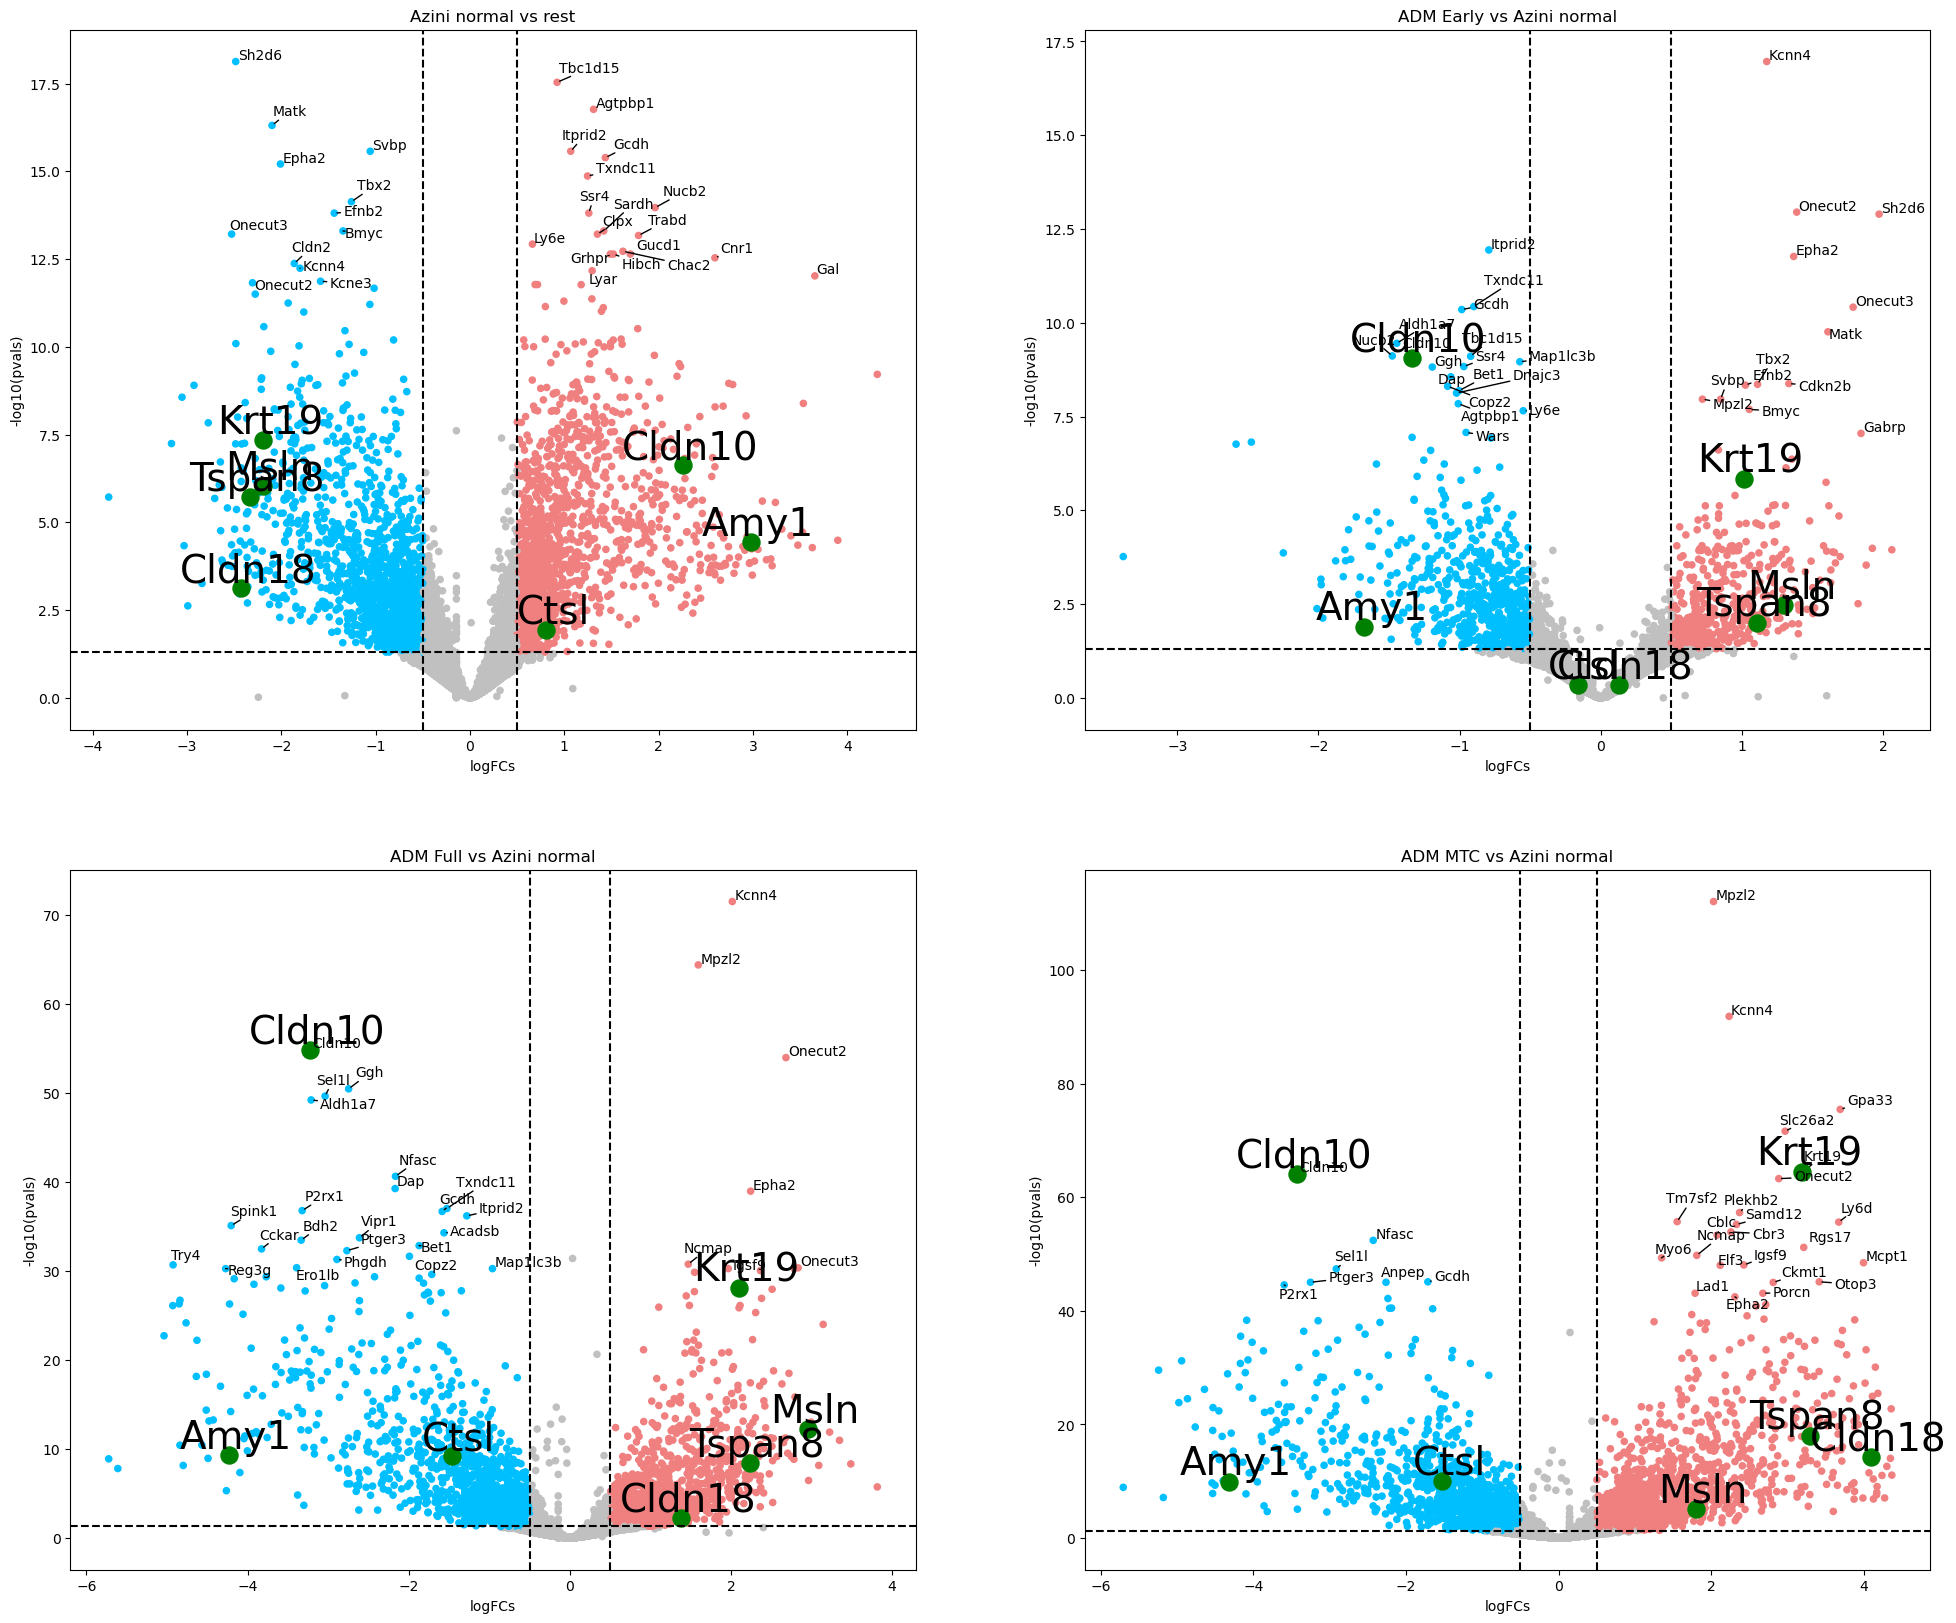

In [13]:
results1=pd.read_csv(f"./diff_exp_genes/CSVs/preneopl_acinar_Azini normal_vs_rest.csv", index_col=0)
results2=pd.read_csv(f"./diff_exp_genes/CSVs/preneopl_acinar_ADM Early_vs_Azini normal.csv", index_col=0)
results3=pd.read_csv(f"./diff_exp_genes/CSVs/preneopl_acinar_ADM Full_vs_Azini normal.csv", index_col=0)
results4=pd.read_csv(f"./diff_exp_genes/CSVs/preneopl_acinar_ADM MTC_vs_Azini normal.csv", index_col=0)
genes= ["Amy1", "Krt19", "Cldn10", "Ctsl", "Msln", "Cldn18", "Tspan8"]

ncols = 2
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12*ncols, 10*nrows)) 

dc.plot_volcano_df(results1, x='log2FoldChange', y='padj', top=30, color_pos="lightcoral", color_neg="deepskyblue", color_null="silver", ax=axs[0,0])
axs[0,0].set_title(f"Azini normal vs rest")

for g in genes:
    gene_row = results1.loc[results1.index == g].copy()
    gene_row["log10padj"] = -np.log10(gene_row["padj"])
    if not gene_row.empty:
        x_gene = gene_row['log2FoldChange'].iloc[0]
        y_gene = gene_row['log10padj'].iloc[0]
        axs[0,0].scatter(x_gene, y_gene, color='green', s=150)
        axs[0,0].annotate(g, (x_gene, y_gene), textcoords="offset points", xytext=(5,5), ha='center', size=28)

dc.plot_volcano_df(results2, x='log2FoldChange', y='padj', top=30, ax=axs[0,1], color_pos="lightcoral", color_neg="deepskyblue", color_null="silver") #, sign_limit=9, lFCs_limit=2.8)
axs[0,1].set_title(f"ADM Early vs Azini normal")

for g in genes:
    gene_row = results2.loc[results2.index == g].copy()
    gene_row["log10padj"] = -np.log10(gene_row["padj"])
    if not gene_row.empty:
        x_gene = gene_row['log2FoldChange'].iloc[0]
        y_gene = gene_row['log10padj'].iloc[0]
        axs[0,1].scatter(x_gene, y_gene, color='green', s=150)
        axs[0,1].annotate(g, (x_gene, y_gene), textcoords="offset points", xytext=(5,5), ha='center', size=28)

dc.plot_volcano_df(results3, x='log2FoldChange', y='padj', top=30, ax=axs[1,0], color_pos="lightcoral", color_neg="deepskyblue", color_null="silver") #, sign_limit=15, lFCs_limit=6, color_pos="lightcoral", color_neg="deepskyblue", color_null="silver")
axs[1,0].set_title(f"ADM Full vs Azini normal")

for g in genes:
    gene_row = results3.loc[results3.index == g].copy()
    gene_row["log10padj"] = -np.log10(gene_row["padj"])
    if not gene_row.empty:
        x_gene = gene_row['log2FoldChange'].iloc[0]
        y_gene = gene_row['log10padj'].iloc[0]
        axs[1,0].scatter(x_gene, y_gene, color='green', s=150)
        axs[1,0].annotate(g, (x_gene, y_gene), textcoords="offset points", xytext=(5,5), ha='center', size=28)

dc.plot_volcano_df(results4, x='log2FoldChange', y='padj', top=30, ax=axs[1,1], color_pos="lightcoral", color_neg="deepskyblue", color_null="silver") #, sign_limit=8, lFCs_limit=4, color_pos="lightcoral", color_neg="deepskyblue", color_null="silver")
axs[1,1].set_title(f"ADM MTC vs Azini normal")

for g in genes:
    gene_row = results4.loc[results4.index == g].copy()
    gene_row["log10padj"] = -np.log10(gene_row["padj"])
    if not gene_row.empty:
        x_gene = gene_row['log2FoldChange'].iloc[0]
        y_gene = gene_row['log10padj'].iloc[0]
        axs[1,1].scatter(x_gene, y_gene, color='green', s=150)
        axs[1,1].annotate(g, (x_gene, y_gene), textcoords="offset points", xytext=(5,5), ha='center', size=28)

plt.savefig("./volcano_preneopl_acinar_top30.tiff", bbox_inches="tight")
plt.savefig("./volcano_preneopl_acinar_top30.pdf", bbox_inches="tight")